In [84]:
import pickle
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import os
from collections import defaultdict
import re
import json
from collections import Counter
import dateutil
from dateutil import parser
from collections import defaultdict
from __future__ import division
import datetime
%pylab inline
from numpy import arange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [85]:
def parseint(string):
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [86]:
with open('movie_info_revised.p' ,'r') as picklefile:
    data = pickle.load(picklefile)

In [87]:
def date_helper(date):
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [88]:
history_keys_dic = defaultdict(dict)
for key in data.keys():
    if 'based on comic book' in data[key]['keywords'] and 'superhero' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_keys_dic['count'][year]= history_keys_dic['count'].get(year, 0) + 1  
history_df = pd.DataFrame.from_dict(history_keys_dic)
start = pd.datetime(1972, 1, 1)
end = pd.datetime(2016, 1, 1)
x = pd.date_range(start, end, freq='A').year
history_df_years = history_df.reindex(x)
history_df = history_df_years.fillna(0)
history_df['rolling mean']=pd.rolling_mean(history_df['count'], 5).shift(+1)
history_df['difference from mean']=history_df['count']/history_df['rolling mean']

In [89]:
history_keys_dic

defaultdict(<type 'dict'>, {'count': {1978: 1, 1980: 1, 1981: 1, 1982: 1, 1983: 1, 1984: 1, 1986: 1, 1987: 1, 1989: 2, 1990: 1, 1991: 2, 1992: 2, 1993: 2, 1994: 3, 1995: 3, 1996: 1, 1997: 2, 1999: 1, 2000: 2, 2002: 3, 2003: 4, 2004: 4, 2005: 6, 2006: 3, 2007: 4, 2008: 6, 2009: 2, 2010: 2, 2011: 5, 2012: 3, 2013: 4, 2014: 3, 2015: 3, 2016: 2}})

In [90]:
history_df

,count,rolling mean,difference from mean
1972,0,NaN,NaN
1973,0,NaN,NaN
1974,0,NaN,NaN
1975,0,NaN,NaN
1976,0,NaN,NaN
1977,0,0.0,NaN
1978,1,0.0,inf
1979,0,0.2,0.000000
1980,1,0.2,5.000000
1981,1,0.4,2.500000


In [91]:
history_dic = defaultdict(dict)
for key in data.keys():
    if 'based on comic book' in data[key]['keywords'] and 'superhero' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_dic[year][key]= defaultdict(dict)
            history_dic[year][key]['date']= data[key]['date']
            history_dic[year][key]['screens']= data[key]['screens']
            history_dic[year][key]['opening']= data[key]['opening']
                #space_dic['space'][year].append(key,)

In [92]:
history_dic

defaultdict(<type 'dict'>, {1978: {'Superman': defaultdict(<type 'dict'>, {'date': '15 December 1978', 'screens': '508', 'opening': '$7,465,343'})}, 1980: {'Flash Gordon': defaultdict(<type 'dict'>, {'date': '5 December 1980', 'screens': '823', 'opening': '$3,934,030'})}, 1981: {'Superman II': defaultdict(<type 'dict'>, {'date': '19 June 1981', 'screens': '1,397', 'opening': '$14,100,523'})}, 1982: {'Swamp Thing': defaultdict(<type 'dict'>, {'date': '19 February 1982', 'screens': 'Error', 'opening': 'N/A'})}, 1983: {'Superman III': defaultdict(<type 'dict'>, {'date': '17 June 1983', 'screens': '1,759', 'opening': '$13,352,357'})}, 1984: {'Supergirl': defaultdict(<type 'dict'>, {'date': '21 November 1984', 'screens': '1,608', 'opening': '$5,738,249'})}, 1986: {'Howard the Duck': defaultdict(<type 'dict'>, {'date': '1 August 1986', 'screens': '1,554', 'opening': '$5,070,136'})}, 1987: {'Superman IV: The Quest for Peace': defaultdict(<type 'dict'>, {'date': '24 July 1987', 'screens': '1,5

In [93]:
def makedf(genre):
    frames = []
    years = []
    for year, movies in genre.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    genre['normalized_opening']= genre['opening']/genre['screens']
    genre = genre[genre.normalized_opening < 17000]
    return genre

In [94]:
genre=makedf(history_dic)

In [95]:
pd.set_option('display.max_rows', 1000)

In [96]:
genre1 = genre[genre.screens > 50]

In [97]:
genre1 = genre1.reset_index()
genre1

,level_0,level_1,date,screens,opening,normalized_opening
0,1978,Superman,1978-12-15,508,7465343,14695.557087
1,1980,Flash Gordon,1980-12-05,823,3934030,4780.109356
2,1981,Superman II,1981-06-19,1397,14100523,10093.430923
3,1983,Superman III,1983-06-17,1759,13352357,7590.879477
4,1984,Supergirl,1984-11-21,1608,5738249,3568.562811
5,1986,Howard the Duck,1986-08-01,1554,5070136,3262.635779
6,1987,Superman IV: The Quest for Peace,1987-07-24,1511,5683122,3761.166115
7,1991,Teenage Mutant Ninja Turtles II: The Secret of...,1991-03-22,2868,20030473,6984.125872
8,1991,The Rocketeer,1991-06-21,1616,9600754,5941.060644
9,1993,Batman: Mask of the Phantasm,1993-12-25,1506,1189975,790.156042


In [98]:
trend = genre1[18:28]


trend

,level_0,level_1,date,screens,opening,normalized_opening
18,2002,Blade II,2002-03-22,2707,32528016,12016.260066
19,2002,Men in Black II,2002-07-03,3557,52148751,14660.880236
20,2003,Daredevil,2003-02-14,3471,40310419,11613.488620
21,2003,Hulk,2003-06-20,3660,62128420,16974.978142
22,2004,Blade: Trinity,2004-12-08,2912,16061271,5515.546360
23,2004,Catwoman,2004-07-23,3117,16728411,5366.830606
24,2004,Hellboy,2004-04-02,3028,23172440,7652.721268
25,2005,Batman Begins,2005-06-15,3858,48745440,12634.898911
26,2005,Elektra,2005-01-14,3204,12804793,3996.502185
27,2005,Son of the Mask,2005-02-18,2966,7511675,2532.594403


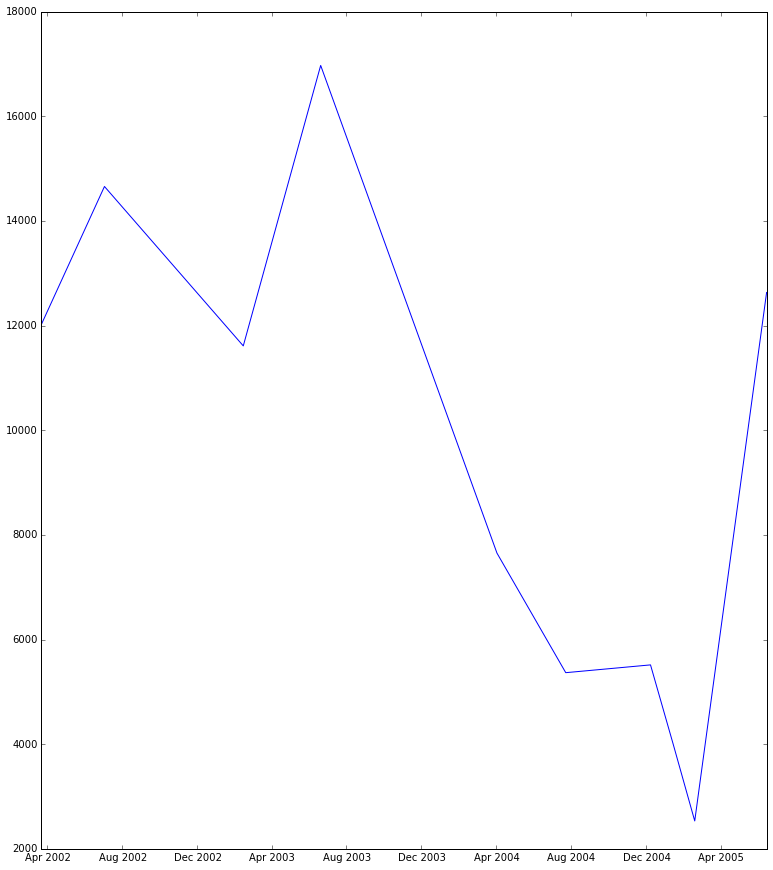

In [99]:
figure(figsize=(13,15))
trend = trend.sort(['date'])
plt.plot(trend['date'], trend['normalized_opening'])

In [100]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('2006-1-13')))

In [101]:
trend

,level_0,level_1,date,screens,opening,normalized_opening,time_delta
18,2002,Blade II,2002-03-22,2707,32528016,12016.260066,-1393 days +00:00:00
19,2002,Men in Black II,2002-07-03,3557,52148751,14660.880236,-1290 days +00:00:00
20,2003,Daredevil,2003-02-14,3471,40310419,11613.488620,-1064 days +00:00:00
21,2003,Hulk,2003-06-20,3660,62128420,16974.978142,-938 days +00:00:00
24,2004,Hellboy,2004-04-02,3028,23172440,7652.721268,-651 days +00:00:00
23,2004,Catwoman,2004-07-23,3117,16728411,5366.830606,-539 days +00:00:00
22,2004,Blade: Trinity,2004-12-08,2912,16061271,5515.546360,-401 days +00:00:00
26,2005,Elektra,2005-01-14,3204,12804793,3996.502185,-364 days +00:00:00
27,2005,Son of the Mask,2005-02-18,2966,7511675,2532.594403,-329 days +00:00:00
25,2005,Batman Begins,2005-06-15,3858,48745440,12634.898911,-212 days +00:00:00


In [102]:
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

In [103]:
def sort_season(x):
    if x in [11, 12, 1]:
        return 4
    if x in [5, 6, 7, 8]:
        return 2
    if x in [9, 10,]:
        return 3
    if x in [2, 3, 4,]:
        return 1
    

In [104]:
trend['season']=trend['date'].apply(lambda x: sort_season(x.month))

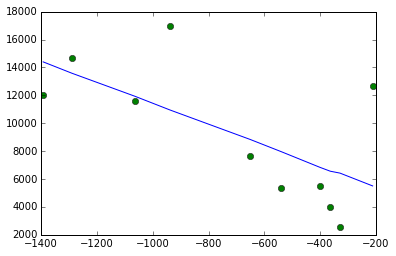

In [105]:
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season', data = trend, return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')


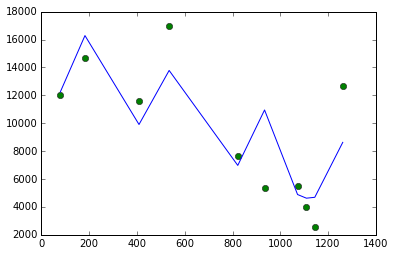

In [109]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('2002-1-01')))
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

def sort_season(x):
    if x in [11, 12, 1]:
        return 'Winter'
    if x in [5, 6, 7, 8]:
        return 'Summer'
    if x in [9, 10,]:
        return 'Fall'
    if x in [2, 3, 4,]:
        return 'Spring'

trend['season']=trend['date'].apply(lambda x: sort_season(x.month))
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season', data = trend.reset_index(), return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')




In [110]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     normalized_opening   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     4.326
Date:                Thu, 08 Oct 2015   Prob (F-statistic):             0.0603
Time:                        20:57:36   Log-Likelihood:                -92.917
No. Observations:                  10   AIC:                             193.8
Df Residuals:                       6   BIC:                             195.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         1.281e+04   2483.138      5.159      0.002      6735.730  1.89e+04
season[T.Summer]  4768.6479   2420.034      1.970      0.096     -1152.963  1.07e+04
season[T.Winter]  -312.5378   3255.921     -0.096      0.927     -8279.489  7654.413
time_delta_num      -7.1006      2.958     -2.401      0.053       -14.338     0.136
==============================================================================
Omnibus:                        1.265   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                0.382
Skew:                          -0.475   Prob(JB):                        0.826
Kurtosis:                       2.886   Cond. No.                     2.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
trend = trend.reset_index()
with open('superheros.p', 'w') as picklefile:
    pickle.dump(trend, picklefile)